### Financial Index Prediction
This notebook seeks to predict the direction of a financial index from day k-1 to day k given financial news headlines from day k. A range of different combinations between statistical and NLP-models are used.

In [58]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.utils import parallel_backend
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.base import ClassifierMixin, BaseEstimator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Embedding, Masking, Lambda, Layer, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
import os
import itertools

#### Load financial news data and financial index data

In [10]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

# Read the financial data 
fin_path = ONEDRIVE_PATH / "Input Data/stock_data.pkl"
fin_data = pd.read_pickle(fin_path)
fin_data = fin_data.loc['2006-10-19' : '2013-11-22']

news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)

In [11]:
news_dates = news_data.index.drop_duplicates()
fin_dates = fin_data.index.drop_duplicates

# Find the dates which are present in both the financial data and news data
valid_dates = []
for date in news_dates: 
    if date in fin_data.index: 
        valid_dates.append(date)
        
# Create targets for all 3 time series 
targets = pd.DataFrame(dtype='int8')
prev_vals = fin_data.iloc[0]
for i in range(len(valid_dates)): 
    y_temp = []
    # If the value has increased since yesterday, y = 1
    if prev_vals['1 YEAR'] < fin_data.iloc[i+1]['1 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['3 YEAR'] < fin_data.iloc[i+1]['3 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['S&P'] < fin_data.iloc[i+1]['S&P']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
    targets = targets.append({'1 YEAR':y_temp[0], '3 YEAR':y_temp[1], 'S&P':y_temp[2]}, ignore_index=True)
    prev_vals = fin_data.iloc[i+1]

In [12]:
# Concatenate the news for each day in the valid indices, i.e. the indices that are present in both 
# the financial data and the news data 
texts = []
for ind,date in enumerate(valid_dates): 
    if not ind % 10: 
        print(round(100 * ind / len(valid_dates), 3),"%     ",end='\r')
    temp_texts = ""
    for i,text in enumerate(news_data.loc[date]['title']): 
        if i < len(news_data.loc[date]['title']) - 1:
            temp_texts += text + ". "
        else:
            temp_texts += text + "."
    texts.append(temp_texts)
print("100 %          ",end='\r')
texts = np.asarray(texts)
print("Length of texts:",len(texts))
print("Length of targets:",len(targets))

Length of texts: 1846
Length of targets: 1846


#### Format the data with SBERT


In [15]:
# Load a pre-trained SBERT-model 
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [31]:
path = ONEDRIVE_PATH / "Input Data/news_embedded_today_bert_base_nli_mean.npy"
# Check if an embedding matrix for the news dataset has been previously constructed 
if os.path.exists(path):
    x = np.load(path)
    embed_dim = x.shape[-1]
    print("Loaded previously saved embeddings.")
else:
    # Create embedding matrix for every sample with the mean embedding over all sentences in that review
    x = np.zeros((len(targets), 768))
    for i,text in enumerate(texts):
        if i % 100: 
            print("{} % ...".format(round(100 * i / len(texts),3)),end='\r')
        sbert_texts = sbert_model.encode(sent_tokenize(text))
        x[i] = np.mean(sbert_texts,axis=0)
    print("100 %           ",end='\r')
    np.save(path,x)

#### Partition into training and test set
Since the data is somewhat imbalanced - mostly for the 1 year rate - the training data will be under sampled by the minority class. 

In [32]:
zero_indices_1yr = np.where(targets['1 YEAR'] == 0)[0]
one_indices_1yr = np.where(targets['1 YEAR'] == 1)[0]

zero_indices_3yr = np.where(targets['3 YEAR'] == 0)[0]
one_indices_3yr = np.where(targets['3 YEAR'] == 1)[0]

zero_indices_sp = np.where(targets['S&P'] == 0)[0]
one_indices_sp = np.where(targets['S&P'] == 1)[0]

print(" ----- 1 YEAR RATE -----")
print("Ratio neg labels 1 year rate:",len(zero_indices_1yr) / len(targets))
print("Neg labels:", len(zero_indices_1yr), "Pos labels:",len(one_indices_1yr))
print(" ----- 3 YEAR RATE -----")
print("Ratio neg labels 3 year rate:",len(zero_indices_3yr) / len(targets))
print("Neg labels:", len(zero_indices_3yr), "Pos labels:",len(one_indices_3yr))
print(" -----     S&P     -----")
print("Ratio neg labels S&P:",len(zero_indices_sp) / len(targets))
print("Neg labels:", len(zero_indices_sp), "Pos labels:",len(one_indices_sp))

 ----- 1 YEAR RATE -----
Ratio neg labels 1 year rate: 0.6890574214517876
Neg labels: 1272 Pos labels: 574
 ----- 3 YEAR RATE -----
Ratio neg labels 3 year rate: 0.5937161430119177
Neg labels: 1096 Pos labels: 750
 -----     S&P     -----
Ratio neg labels S&P: 0.4637053087757313
Neg labels: 856 Pos labels: 990


In [34]:
n_train = 1000

np.random.shuffle(zero_indices_1yr)
np.random.shuffle(one_indices_1yr)
train_indices_1yr = np.zeros((n_train),dtype=int)
train_indices_1yr[:int(n_train / 2)] = zero_indices_1yr[:int(n_train / 2)]
train_indices_1yr[int(n_train / 2):] = one_indices_1yr[:int(n_train / 2)]
np.random.shuffle(train_indices_1yr)
test_indices_1yr = np.setdiff1d(np.arange(len(targets)), train_indices_1yr)
np.random.shuffle(test_indices_1yr)

np.random.shuffle(zero_indices_3yr)
np.random.shuffle(one_indices_3yr)
train_indices_3yr = np.zeros((n_train),dtype=int)
train_indices_3yr[:int(n_train / 2)] = zero_indices_3yr[:int(n_train / 2)]
train_indices_3yr[int(n_train / 2):] = one_indices_3yr[:int(n_train / 2)]
np.random.shuffle(train_indices_3yr)
test_indices_3yr = np.setdiff1d(np.arange(len(targets)), train_indices_3yr)
np.random.shuffle(test_indices_3yr)

np.random.shuffle(zero_indices_sp)
np.random.shuffle(one_indices_sp)
train_indices_sp = np.zeros((n_train),dtype=int)
train_indices_sp[:int(n_train / 2)] = zero_indices_sp[:int(n_train / 2)]
train_indices_sp[int(n_train / 2):] = one_indices_sp[:int(n_train / 2)]
np.random.shuffle(train_indices_sp)
test_indices_sp = np.setdiff1d(np.arange(len(targets)), train_indices_sp)
np.random.shuffle(test_indices_sp)

texts_train_1yr = texts[train_indices_1yr]
texts_test_1yr = texts[test_indices_1yr]
x_train_1yr = x[train_indices_1yr]
x_test_1yr = x[test_indices_1yr]
y_train_1yr = targets.iloc[train_indices_1yr]['1 YEAR'].values
y_test_1yr = targets.iloc[test_indices_1yr]['1 YEAR'].values

texts_train_3yr = texts[train_indices_3yr]
texts_test_3yr = texts[test_indices_3yr]
x_train_3yr = x[train_indices_3yr]
x_test_3yr = x[test_indices_3yr]
y_train_3yr = targets.iloc[train_indices_3yr]['3 YEAR'].values
y_test_3yr = targets.iloc[test_indices_3yr]['3 YEAR'].values

texts_train_sp = texts[train_indices_sp]
texts_test_sp = texts[test_indices_sp]
x_train_sp = x[train_indices_sp]
x_test_sp = x[test_indices_sp]
y_train_sp = targets.iloc[train_indices_sp]['S&P'].values
y_test_sp = targets.iloc[test_indices_sp]['S&P'].values

# Sanity check of shapes 

print(" ----- 1 YEAR RATE -----")
print("Train data shape (x,y):",x_train_1yr.shape,",", y_train_1yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_1yr == 0),"/", np.sum(y_train_1yr == 1))
print("Test data shape (x,y):",x_test_1yr.shape,",", y_test_1yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_1yr == 0),"/", np.sum(y_test_1yr == 1))

print(" ----- 3 YEAR RATE -----")
print("Train data shape (x,y):",x_train_3yr.shape,",", y_train_3yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_3yr == 0),"/", np.sum(y_train_3yr == 1))
print("Test data shape (x,y):",x_test_3yr.shape,",", y_test_3yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_3yr == 0),"/", np.sum(y_test_3yr == 1))
print(" -----     S&P     -----")
print("Train data shape (x,y):",x_train_sp.shape,",", y_train_sp.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_sp == 0),"/", np.sum(y_train_sp == 1))
print("Test data shape (x,y):",x_test_sp.shape,",", y_test_sp.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_sp == 0),"/", np.sum(y_test_sp == 1))

 ----- 1 YEAR RATE -----
Train data shape (x,y): (1000, 768) , (1000,)
Train data label ratio (0 / 1): 500 / 500
Test data shape (x,y): (846, 768) , (846,)
Test data label ratio (0 / 1): 772 / 74
 ----- 3 YEAR RATE -----
Train data shape (x,y): (1000, 768) , (1000,)
Train data label ratio (0 / 1): 500 / 500
Test data shape (x,y): (846, 768) , (846,)
Test data label ratio (0 / 1): 596 / 250
 -----     S&P     -----
Train data shape (x,y): (1000, 768) , (1000,)
Train data label ratio (0 / 1): 500 / 500
Test data shape (x,y): (846, 768) , (846,)
Test data label ratio (0 / 1): 356 / 490


## Models 
The data has been pre-processed and the models can be evaluated. All of the models are fitted with the three data series. 

In [35]:
# Some help functions for plotting the results 

def plot_results(model,x_test, y_test,save=False, name=''):
    y_test_preds = model.predict(x_test)
    print(classification_report(y_test, y_test_preds))
    print("Test accuracy:",model.score(x_test, y_test))
    plot_confusion_matrix(model,x_test,y_test)
    if save:
        plt.savefig("Figs SBERT/" + name + "confmat.jpg")
    plt.show()
    
def plot_results_nn(history, model,x_test, y_test,save=False, name=''):
    plt.subplot(121)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['acc'],label='Acc')
    plt.plot(history.history['val_acc'],label='Val acc')
    plt.legend()
    if save: 
        plt.savefig("Figs SBERT/" + name + "history.jpg")
    plt.show() 
    y_test_pred = np.round(model.predict(x_test))
    plt.subplot(121)
    plt.bar([0,1],[np.sum(y_test == 0), np.sum(y_test == 1)], label='Actual test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.subplot(122)
    plt.bar([0,1],[np.sum(y_test_pred == 0), np.sum(y_test_pred == 1)], label='Pred test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    if save: 
        plt.savefig("Figs SBERT/" + name + "confmat.jpg")
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print("Test accuracy:",round(np.sum(y_test == y_test_pred[:,0]) / len(y_test),3))

## Random Classifier
Just for real simple comparison. 
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.89      0.50      0.64       772
         1.0       0.07      0.38      0.12        74

    accuracy                           0.49       846
   macro avg       0.48      0.44      0.38       846
weighted avg       0.82      0.49      0.60       846

Test accuracy: 0.5200945626477541


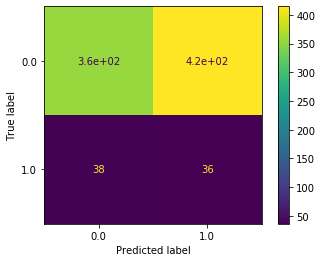

In [38]:
# Dummy Classifier
dummy_clf_1yr = DummyClassifier().fit(x_train_1yr, y_train_1yr)
plot_results(dummy_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='randclf_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.71      0.54      0.61       596
         1.0       0.30      0.48      0.37       250

    accuracy                           0.52       846
   macro avg       0.51      0.51      0.49       846
weighted avg       0.59      0.52      0.54       846

Test accuracy: 0.4858156028368794


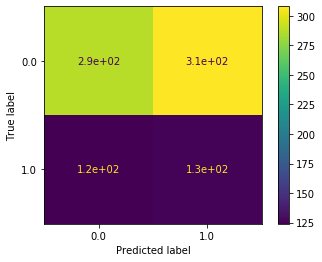

In [39]:
# Dummy Classifier
dummy_clf_3yr = DummyClassifier().fit(x_train_3yr, y_train_3yr)
plot_results(dummy_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='randclf_3yr')

#### S&P

              precision    recall  f1-score   support

         0.0       0.41      0.49      0.45       356
         1.0       0.57      0.50      0.53       490

    accuracy                           0.49       846
   macro avg       0.49      0.49      0.49       846
weighted avg       0.51      0.49      0.50       846

Test accuracy: 0.508274231678487


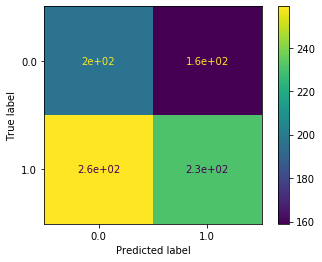

In [40]:
# Dummy Classifier
dummy_clf_sp = DummyClassifier().fit(x_train_sp, y_train_sp)
plot_results(dummy_clf_sp, x_test_sp, y_test_sp,save=True,name='randclf_sp')

### Logistic Regression with SBERT
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.93      0.57      0.71       772
         1.0       0.12      0.58      0.19        74

    accuracy                           0.57       846
   macro avg       0.53      0.58      0.45       846
weighted avg       0.86      0.57      0.67       846

Test accuracy: 0.574468085106383


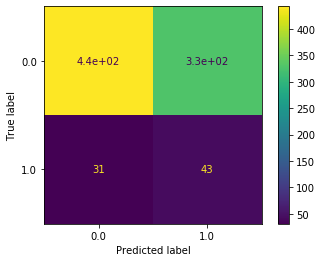

In [43]:
# Logistic regression
logreg_1yr = LogisticRegression(random_state=0,max_iter=10000).fit(x_train_1yr, y_train_1yr)
plot_results(logreg_1yr,x_test_1yr, y_test_1yr,save=True,name='logreg_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.79      0.54      0.64       596
         1.0       0.38      0.67      0.48       250

    accuracy                           0.58       846
   macro avg       0.59      0.60      0.56       846
weighted avg       0.67      0.58      0.59       846

Test accuracy: 0.5768321513002365


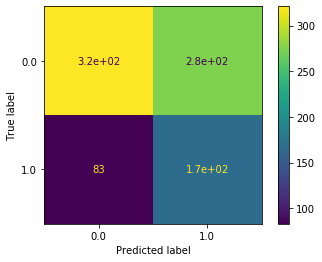

In [44]:
# Logistic regression
logreg_3yr = LogisticRegression(random_state=0,max_iter=10000).fit(x_train_3yr, y_train_3yr)
plot_results(logreg_3yr,x_test_3yr, y_test_3yr,save=True,name='logreg_3yr')

#### S&P 

              precision    recall  f1-score   support

         0.0       0.54      0.55      0.55       356
         1.0       0.67      0.66      0.67       490

    accuracy                           0.62       846
   macro avg       0.61      0.61      0.61       846
weighted avg       0.62      0.62      0.62       846

Test accuracy: 0.6158392434988179


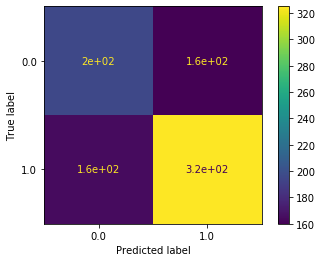

In [45]:
# Logistic regression
logreg_sp = LogisticRegression(random_state=0,max_iter=10000).fit(x_train_sp, y_train_sp)
plot_results(logreg_sp,x_test_sp, y_test_sp,save=True,name='logreg_sp')

### Support Vector Machine with SBERT
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.95      0.57      0.71       772
         1.0       0.14      0.70      0.23        74

    accuracy                           0.58       846
   macro avg       0.54      0.64      0.47       846
weighted avg       0.88      0.58      0.67       846

Test accuracy: 0.5803782505910166


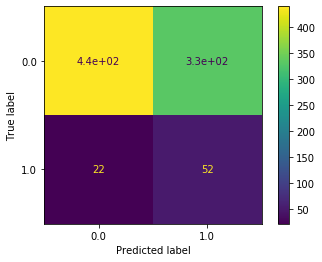

In [46]:
svm_clf_1yr = svm.SVC().fit(x_train_1yr, y_train_1yr)
plot_results(svm_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='svm_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.79      0.61      0.69       596
         1.0       0.40      0.62      0.48       250

    accuracy                           0.61       846
   macro avg       0.59      0.61      0.58       846
weighted avg       0.67      0.61      0.63       846

Test accuracy: 0.6087470449172577


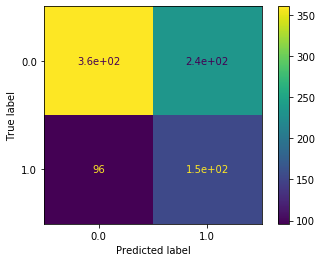

In [47]:
svm_clf_3yr = svm.SVC().fit(x_train_3yr, y_train_3yr)
plot_results(svm_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='svm_3yr')

#### S&P 

              precision    recall  f1-score   support

         0.0       0.52      0.58      0.55       356
         1.0       0.67      0.61      0.64       490

    accuracy                           0.60       846
   macro avg       0.60      0.60      0.59       846
weighted avg       0.61      0.60      0.60       846

Test accuracy: 0.599290780141844


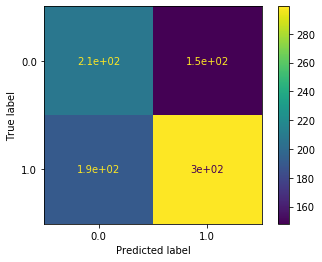

In [48]:
svm_clf_sp = svm.SVC().fit(x_train_sp, y_train_sp)
plot_results(svm_clf_sp, x_test_sp, y_test_sp,save=True,name='svm_sp')

### Random forest with SBERT
#### 1 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.1min finished


Best: 0.566821 using {'max_depth': 100, 'n_estimators': 500}
0.536312 (0.048260) with: {'max_depth': None, 'n_estimators': 250}
0.548123 (0.046752) with: {'max_depth': None, 'n_estimators': 500}
0.545466 (0.035401) with: {'max_depth': None, 'n_estimators': 750}
0.544658 (0.031916) with: {'max_depth': None, 'n_estimators': 1000}
0.538643 (0.056626) with: {'max_depth': 50, 'n_estimators': 250}
0.539219 (0.046297) with: {'max_depth': 50, 'n_estimators': 500}
0.539574 (0.039153) with: {'max_depth': 50, 'n_estimators': 750}
0.563144 (0.031210) with: {'max_depth': 50, 'n_estimators': 1000}
0.557703 (0.056338) with: {'max_depth': 100, 'n_estimators': 250}
0.566821 (0.052060) with: {'max_depth': 100, 'n_estimators': 500}
0.541427 (0.055354) with: {'max_depth': 100, 'n_estimators': 750}
0.546258 (0.041137) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.94      0.57      0.71       772
         1.0       0.13      0.65  

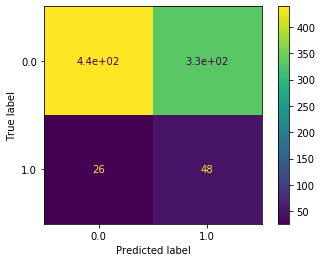

In [51]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_1yr, y_train_1yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_1yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_1yr, y_train_1yr)
plot_results(randomforest_1yr,x_test_1yr, y_test_1yr,save=True,name='rf_1yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### 3 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.8min finished


Best: 0.554733 using {'max_depth': None, 'n_estimators': 1000}
0.514419 (0.053533) with: {'max_depth': None, 'n_estimators': 250}
0.526556 (0.030565) with: {'max_depth': None, 'n_estimators': 500}
0.534211 (0.036453) with: {'max_depth': None, 'n_estimators': 750}
0.554733 (0.045469) with: {'max_depth': None, 'n_estimators': 1000}
0.539226 (0.028389) with: {'max_depth': 50, 'n_estimators': 250}
0.538699 (0.041534) with: {'max_depth': 50, 'n_estimators': 500}
0.548483 (0.031492) with: {'max_depth': 50, 'n_estimators': 750}
0.541302 (0.043856) with: {'max_depth': 50, 'n_estimators': 1000}
0.545863 (0.048445) with: {'max_depth': 100, 'n_estimators': 250}
0.535367 (0.050463) with: {'max_depth': 100, 'n_estimators': 500}
0.530690 (0.027503) with: {'max_depth': 100, 'n_estimators': 750}
0.542991 (0.043639) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.74      0.56      0.64       596
         1.0       0.34      0.54

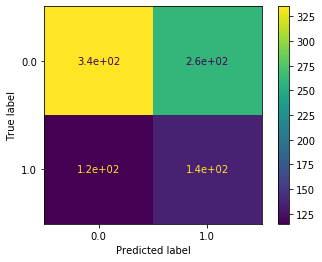

In [52]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_3yr, y_train_3yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_3yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_3yr, y_train_3yr)
plot_results(randomforest_3yr,x_test_3yr, y_test_3yr,save=True,name='rf_3yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### S&P 

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.0min finished


Best: 0.592277 using {'max_depth': 50, 'n_estimators': 750}
0.576786 (0.042809) with: {'max_depth': None, 'n_estimators': 250}
0.588368 (0.045003) with: {'max_depth': None, 'n_estimators': 500}
0.582976 (0.038684) with: {'max_depth': None, 'n_estimators': 750}
0.579646 (0.033046) with: {'max_depth': None, 'n_estimators': 1000}
0.571147 (0.041428) with: {'max_depth': 50, 'n_estimators': 250}
0.584518 (0.029887) with: {'max_depth': 50, 'n_estimators': 500}
0.592277 (0.041574) with: {'max_depth': 50, 'n_estimators': 750}
0.584000 (0.040335) with: {'max_depth': 50, 'n_estimators': 1000}
0.575857 (0.039122) with: {'max_depth': 100, 'n_estimators': 250}
0.583943 (0.033550) with: {'max_depth': 100, 'n_estimators': 500}
0.579367 (0.030034) with: {'max_depth': 100, 'n_estimators': 750}
0.579444 (0.045013) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.52      0.58      0.55       356
         1.0       0.67      0.61   

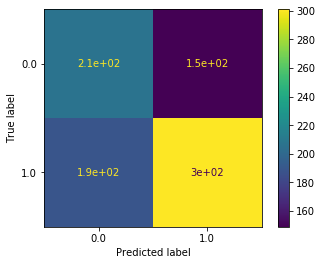

In [53]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_sp, y_train_sp)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_sp = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_sp, y_train_sp)
plot_results(randomforest_sp,x_test_sp, y_test_sp,save=True,name='rf_sp_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

### Neural Network, feed-forward

In [59]:
def create_model_ff(nodes1=100, nodes2=50, n_hidden=2, dropout_rate=0.3, optimizer='rmsprop', learning_rate=0.001):
    if optimizer == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential() 
    if n_hidden == 0: 
        model.add(Dense(1, input_shape=x_train_1yr.shape[1:], activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    model.add(Dense(nodes1, input_shape=x_train_1yr.shape[1:]))
    model.add(Dropout(dropout_rate))
    if n_hidden == 1: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model
    if n_hidden == 2:  
        model.add(Dense(nodes2))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    print("Not yet implemented hidden layers > 2. ")
    return None

earlystop = EarlyStopping(monitor='val_loss',
                          patience=3,
                          restore_best_weights=True)

#### 1 year rate

In [70]:
#m = create_model_ff(nodes1=10, n_hidden=1, dropout_rate=0.5, optimizer='rmsprop', learning_rate=1e-5)
m_h = m.fit(x_train_1yr, y_train_1yr,
           batch_size=16,
           validation_split=0.2,
           epochs=200)

Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 0s 244us/sample - loss: 0.6889 - acc: 0.5550 - val_loss: 0.6982 - val_acc: 0.4700
Epoch 2/200
800/800 [==============================] - 0s 270us/sample - loss: 0.6911 - acc: 0.5263 - val_loss: 0.6990 - val_acc: 0.4700
Epoch 3/200
800/800 [==============================] - 0s 247us/sample - loss: 0.6895 - acc: 0.5437 - val_loss: 0.6984 - val_acc: 0.4650
Epoch 4/200
800/800 [==============================] - 0s 250us/sample - loss: 0.6872 - acc: 0.5250 - val_loss: 0.6987 - val_acc: 0.4700
Epoch 5/200
800/800 [==============================] - 0s 250us/sample - loss: 0.6926 - acc: 0.5138 - val_loss: 0.6986 - val_acc: 0.4650
Epoch 6/200
800/800 [==============================] - 0s 243us/sample - loss: 0.6894 - acc: 0.5437 - val_loss: 0.6986 - val_acc: 0.4650
Epoch 7/200
800/800 [==============================] - 0s 181us/sample - loss: 0.6912 - acc: 0.5063 - val_loss: 0.6984 - val_acc: 0.

800/800 [==============================] - 0s 249us/sample - loss: 0.6887 - acc: 0.5450 - val_loss: 0.6996 - val_acc: 0.4900
Epoch 120/200
800/800 [==============================] - 0s 251us/sample - loss: 0.6826 - acc: 0.5525 - val_loss: 0.7008 - val_acc: 0.4800
Epoch 121/200
800/800 [==============================] - 0s 265us/sample - loss: 0.6778 - acc: 0.5625 - val_loss: 0.7008 - val_acc: 0.4800
Epoch 122/200
800/800 [==============================] - 0s 228us/sample - loss: 0.6813 - acc: 0.5688 - val_loss: 0.6997 - val_acc: 0.4900
Epoch 123/200
800/800 [==============================] - 0s 274us/sample - loss: 0.6837 - acc: 0.5800 - val_loss: 0.7000 - val_acc: 0.4850
Epoch 124/200
800/800 [==============================] - 0s 248us/sample - loss: 0.6814 - acc: 0.5437 - val_loss: 0.6997 - val_acc: 0.4850
Epoch 125/200
800/800 [==============================] - 0s 251us/sample - loss: 0.6840 - acc: 0.5500 - val_loss: 0.7015 - val_acc: 0.4900
Epoch 126/200
800/800 [==================

800/800 [==============================] - 0s 250us/sample - loss: 0.6828 - acc: 0.5537 - val_loss: 0.7004 - val_acc: 0.4900
Epoch 179/200
800/800 [==============================] - 0s 249us/sample - loss: 0.6801 - acc: 0.5700 - val_loss: 0.7000 - val_acc: 0.5000
Epoch 180/200
800/800 [==============================] - 0s 253us/sample - loss: 0.6808 - acc: 0.5688 - val_loss: 0.7003 - val_acc: 0.4950
Epoch 181/200
800/800 [==============================] - 0s 247us/sample - loss: 0.6823 - acc: 0.5500 - val_loss: 0.7002 - val_acc: 0.4900
Epoch 182/200
800/800 [==============================] - 0s 253us/sample - loss: 0.6771 - acc: 0.5763 - val_loss: 0.7003 - val_acc: 0.4950
Epoch 183/200
800/800 [==============================] - 0s 248us/sample - loss: 0.6861 - acc: 0.5612 - val_loss: 0.7011 - val_acc: 0.4800
Epoch 184/200
800/800 [==============================] - 0s 251us/sample - loss: 0.6792 - acc: 0.5775 - val_loss: 0.7000 - val_acc: 0.5000
Epoch 185/200
800/800 [==================

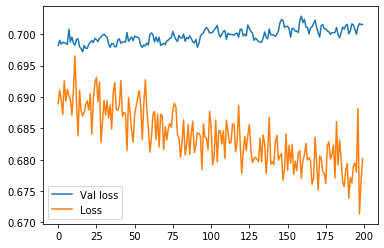

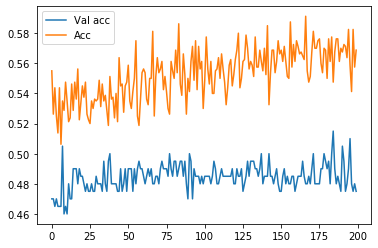

In [71]:
plt.plot(m_h.history['val_loss'],label='Val loss')
plt.plot(m_h.history['loss'],label='Loss')
plt.legend()
plt.show()
plt.plot(m_h.history['val_acc'],label='Val acc')
plt.plot(m_h.history['acc'],label='Acc')
plt.legend()
plt.show()

In [72]:
# Perform a cross-validation to find good values of hyperparameters

model_1yr = KerasClassifier(build_fn=create_model_ff, verbose=0)
# define the grid search parameters
batch_size = [8, 16, 32]
epochs = [20, 40]
learning_rates = [1e-3, 1e-4, 1e-5]
nodes1 = [10,100, 250, 500, 750]
nodes2 = [10,100, 250, 500, 750]
n_hidden = [0,1,2]
dropout_rates = [0.2, 0.5]
optimizers = ['rmsprop','adam']
nn_param_grid = dict(batch_size=batch_size,
                     epochs=epochs,
                     nodes1=nodes1,
                     nodes2=nodes2,
                     dropout_rate=dropout_rates,
                     learning_rate=learning_rates,
                     n_hidden=n_hidden,
                     optimizer=optimizers)
nn_grid = GridSearchCV(estimator=model_1yr,
                       param_grid=nn_param_grid,
                       n_jobs=-1,
                       cv=2,
                       verbose=10)
with parallel_backend('threading'):    # This is a bug work-around to allow parallel computation mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    nn_grid_result = nn_grid.fit(x_train_1yr, y_train_1yr)
# summarize results
print("Best: %f using %s" % (nn_grid_result.best_score_, nn_grid_result.best_params_))
means = nn_grid_result.cv_results_['mean_test_score']
stds = nn_grid_result.cv_results_['std_test_score']
params = nn_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
model_1yr = create_model_ff(nodes=nn_grid_result.best_params_['nodes'],
                     n_hidden=nn_grid_result.best_params_['n_hidden'],
                     dropout_rate=nn_grid_result.best_params_['dropout_rate'])

history_1yr = model_1yr.fit(x_train_1yr, y_train_1yr,
                            validation_split=0.2,
                            epochs=1000000,
                            batch_size=nn_grid_result.best_params_['batch_size'],
                            callbacks=[EarlyStopping(patience=10,restore_best_weights=True)],
                            verbose=1)

plot_results_nn(history_1yr,
                model_1yr,
                x_test_1yr,
                y_test_1yr,
                save=True,
                name='nn_1yr_n1{}_n2{}_de{}_dr{}'.format(nn_grid_result.best_params_['nodes1'],
                                                         nn_grid_result.best_params_['nodes2'],
                                                         nn_grid_result.best_params_['n_hidden'],
                                                         nn_grid_result.best_params_['dropout_rate']))

Fitting 2 folds for each of 2304 candidates, totalling 4608 fits
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam [CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam 
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=100, optimizer=rmsprop 

[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=100, optimizer=rmsprop 
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=100, optimizer=adam 
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam, score=0.530, total=  21.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.530, total=  22.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam, score=0.528, total=  22.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.1s


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.536, total=  22.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=100, optimizer=adam, score=0.552, total=  22.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=100, optimizer=adam, score=0.556, total=  22.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.546, total=  23.0s
[CV] batch_size=8, dropout_rate=0.2, 

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_1987/dense_1_loss/add'

  FitFailedWarning)
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.3s
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_1985/dense_1_loss/mul_1'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam, score=0.558, total=  13.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.526, total=  12.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=500, optimizer=adam, score=0.542, total=  12.7s
[CV] batch_size=8, dropout_rate=0.2, epoc

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   36.0s


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.524, total=  12.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=500, optimizer=adam, score=0.550, total=  13.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_1997/dense_2_loss/add_2'

  FitFailedWarning)
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_1998/dense_2_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=nan, total=   0.5s[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=100, optimizer=rmsprop, score=nan, total=   0.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam 

[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.536, total=   9.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.528, total=  10.1s
[CV] batch_size=8, dropout_rate=0.2, 

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   46.3s


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.520, total=  10.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam, score=nan, total=   0.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_2006/dense_5_loss/weighted_loss/broadcast_weights/ones_like'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.558, total=  13.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam, score=0.520, total=   8.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.570, total=   8.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.536, total=   8.7s
[CV] batch_size=8, dropout_rate

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.1s


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.548, total=   8.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop, score=nan, total=   0.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_2017/dense_5_loss/weighted_loss/broadcast_weights/ones_like/Shape'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.544, total=  10.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam, score=0.526, total=   8.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.526, total=   8.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam, score=0.540, total=   8.7s
[CV] batch_size=8, dropout_rate=

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.536, total=  10.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam, score=0.554, total=  10.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.544, total=  10.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.536, total=  10.3s
[CV] batch_size=8, dropout_rate=0.

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.4min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.546, total=   8.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.536, total=   9.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.550, total=   9.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.574, total=   9.1s
[CV] batch_size=8, dropout_rate=0.2

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.6min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.514, total=  11.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam, score=0.542, total=  10.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam, score=0.526, total=  10.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=250, optimizer=adam, score=0.544, total=  10.2s
[CV] batch_size=8, dropout_rate=0.2, epoch

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_2058/dense_13_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=nan, total=   0.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.506, total=  12.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam, score=0.532, total=  11.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam, score=0.546, total=  11.8s
[CV] batch_size=8, dropout_rate=0.2, e

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.0min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.504, total=  13.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.494, total=  18.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.506, total=  13.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.554, total=  11.6s
[CV] batch_size=8, dropout_rate

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.4min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.542, total=  14.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=adam, score=0.550, total=  13.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.542, total=  14.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.554, total=  14.3s
[CV] batch_size=8, dropout_rate=

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.8min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.542, total=  19.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.504, total=  18.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.506, total=  25.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.530, total=  25.7s
[CV] batch_size=8, dropout_rate=0

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.6min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.528, total=  13.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.498, total=  13.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.546, total=  14.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=adam, score=0.570, total=  13.1s
[CV] batch_size=8, dropout_rate=0.2, epoc

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe7 in position 2: invalid continuation byte

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.552, total=  13.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam, score=0.562, total=  12.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.546, total=  13.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam, score=0.552, total=  12.1s
[CV] batch_size=8, dropout_rate=0.2, ep

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.1min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam, score=0.530, total=  13.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.550, total=  14.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.516, total=  15.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam, score=0.520, total=  13.5s
[CV] batch_size=8, dropout_rate=0.

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_2132/dense_35_loss/add'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop, score=nan, total=   0.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.504, total=  15.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.508, total=  17.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam, score=0.542, total=  15.1s
[CV] batch_size=8, dropout_rat

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_4286/acc/div_no_nan/ReadVariableOp'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop, score=nan, total=   1.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=10, optimizer=adam, score=0.536, total=  14.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=10, optimizer=adam, score=0.504, total=  15.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  4.6min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.518, total=  17.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.542, total=  16.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.492, total=  18.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.556, total=  15.8s
[CV] batch_size=8, dropout_rate=

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.5min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.506, total=  24.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.506, total=  21.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.536, total=  23.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.500, total=  29.1s
[CV] batch_size=8, dropout_rate=

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_2181/dense_49_loss/add'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=500, optimizer=adam, score=nan, total=   0.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.562, total=  10.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam, score=0.560, total=   9.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.548, total=   9.8s
[CV] batch_size=8, dropout_rate

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  6.1min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.508, total=  10.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.562, total=  11.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=500, optimizer=adam, score=0.544, total=  11.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_2189/dense_50_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=nan, total=   0.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.548, total=  11.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.536, total=  10.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.554, total=  10.9s
[CV] batch_size=8, dropout_

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  6.6min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.512, total=   9.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.526, total=  10.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.558, total=   9.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.544, total=  11.4s
[CV] batch_size=8, dropo

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  7.1min



[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.558, total=   9.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.542, total=   9.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.534, total=  11.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.534, total=  10.2s
[CV] batch_size=8, dropout_ra

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_4482/acc/Cast_3'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop, score=nan, total=   0.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.526, total=  12.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam, score=0.540, total=  11.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.560, total=  12.2s
[CV] batch_size=8, dropout_r

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  7.7min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.546, total=  14.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.508, total=  12.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.552, total=  13.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.502, total=  14.3s
[CV] batch_size=8, dropout

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_2257/dense_61_loss/clip_by_value'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam, score=nan, total=   0.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.512, total=  20.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.508, total=  12.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.548, total=  12.5s
[CV] batch_size=8, dropout_

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  8.4min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam, score=0.534, total=  15.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam, score=0.550, total=  15.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.510, total=  16.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.536, total=  18.2s
[CV] batch_size=8, dropout_r

[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  9.5min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.594, total=  13.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.544, total=  13.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.528, total=  14.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.562, total=  14.6s
[CV] batch_size=8, dropout_rate=0.

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_35_12/dropout/Cast'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.554, total=  15.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam, score=0.550, total=  14.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam, score=0.546, total=  15.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.546, total=  21.6s
[CV] batch_size=8, dropout_rate=

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.4min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=500, optimizer=adam, score=0.526, total=  17.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=500, optimizer=adam, score=0.528, total=  16.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.560, total=  19.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.502, total=  18.1s
[CV] batch_size=8, dropout

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 11.7min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.540, total=  26.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.508, total=  29.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.514, total=  37.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.538, total=  35.5s
[CV] batch_size=8, dropout_rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_2367/dense_95_loss/mul_1'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=nan, total=   0.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam, score=0.490, total=  14.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.514, total=  11.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=100, optimizer=adam, score=0.488, total=  10.9s
[CV] batch_size=8, dropout_rate=0.2, ep

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 12.6min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.486, total=  11.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.514, total=  11.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.506, total=  11.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.552, total=  11.4s
[CV] batch_size=8, dropout_rate=

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 13.3min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.508, total=  11.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.526, total=  11.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.500, total=  12.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.484, total=  11.5s
[CV] batch_size=8, dropout_rate

[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 14.2min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.530, total=  13.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.528, total=  14.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.518, total=  14.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.552, total=  14.3s
[CV] batch_size=8, dropout_rate=0.2

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_4914/acc/Sum'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop, score=nan, total=   0.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam, score=0.560, total=  15.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.572, total=  17.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.538, total=  17.1s
[CV] batch_size=8, dropout_ra

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 15.2min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.548, total=  20.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.554, total=  21.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.540, total=  26.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.554, total=  26.7s
[CV] batch_size=8, dropout_rate=0

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_2507/dense_131_loss/mul_1'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop, score=nan, total=   1.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.562, total=  16.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop 


[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 16.5min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam, score=0.530, total=  15.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.546, total=  16.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.532, total=  16.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam, score=0.502, total=  15.6s
[CV] batch_size=8, dropout_rate=0.2,

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_5050/acc/Size'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=nan, total=   1.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=10, optimizer=adam, score=0.512, total=  16.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.560, total=  18.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.544, total=  18.3s
[CV] batch_size=8, dropout_rate=0.

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_5076/acc/Size'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam, score=nan, total=   1.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.556, total=  23.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.568, total=  21.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.546, total=  22.6s
[CV] batch_size=8, dropout_rate=0.2, e

[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 18.0min


[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.562, total=  32.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.538, total=  32.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.550, total=  37.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.528, total=  37.5s
[CV] batch_size=8, dropout_r

[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.528, total=  18.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.532, total=  18.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.534, total=  18.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.536, total=  18.2s
[CV] batch_size=8, dropout_rate=0.2

[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 19.7min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.530, total=  18.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.546, total=  18.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.538, total=  17.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.518, total=  19.9s
[CV] batch_size=8, dropout_rate=

[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.536, total=  16.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.544, total=  17.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam, score=0.550, total=  16.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam, score=0.524, total=  17.2s
[CV] batch_size=8, dropout_ra

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 20.9min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.540, total=  18.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.522, total=  17.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.538, total=  17.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.544, total=  17.1s
[CV] batch_size=8, dropout_rate=0.2

[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.508, total=  22.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.508, total=  25.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam, score=0.548, total=  22.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam, score=0.528, total=  22.5s
[CV] batch_size=8, dropout_rate=0.

[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 22.6min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam, score=0.538, total=  24.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.552, total=  26.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=adam, score=0.538, total=  26.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=adam, score=0.550, total=  26.5s
[CV] batch_size=8, dropout_rate=0.2, 

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_2680/dense_173_loss/mul_1'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop, score=nan, total=   1.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.490, total=  53.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam, score=0.546, total=  37.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam, score=0.530, total=  37.5s
[CV] batch_size=8, dropout_rate=0.2, 

[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 25.4min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.544, total=  27.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.522, total=  25.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.520, total=  27.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.530, total=  24.1s
[CV] batch_size=8, dropout_rate=0.2, e

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_86_13/dropout/mul'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop, score=nan, total=   1.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.522, total=  30.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.524, total=  30.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam, score=0.510, total=  27.5s
[CV] batch_size=8, dropout_rate=

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_88_15/dropout/random_uniform/RandomUniform'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=nan, total=   1.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.516, total=  34.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop 


[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 27.5min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.544, total=  37.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=250, optimizer=adam, score=0.544, total=  34.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=250, optimizer=adam, score=0.544, total=  34.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.506, total=  38.4s
[CV] batch_size=8, dropout_rate=0.2

[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.576, total=  19.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.538, total=  19.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam, score=0.564, total=  18.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam, score=0.562, total=  18.7s
[CV] batch_size=8, dropout_ra

[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 30.5min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.528, total=  18.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.534, total=  18.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.544, total=  18.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.546, total=  19.4s
[CV] batch_size=8, dropout

[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam, score=0.566, total=  17.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam, score=0.528, total=  18.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.534, total=  18.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.564, total=  17.8s
[CV] batch_size=8, dropout_

[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed: 32.0min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.578, total=  17.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.572, total=  17.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.552, total=  18.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.536, total=  17.4s
[CV] batch_size=8, dropout_rate

[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.538, total=  22.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam, score=0.550, total=  22.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.546, total=  25.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.544, total=  25.9s
[CV] batch_size=8, dropo

[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 34.1min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=10, optimizer=adam, score=0.550, total=  25.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.532, total=  28.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam, score=0.542, total=  26.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam, score=0.548, total=  26.3s
[CV] batch_size=8, dropout_rat

[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.546, total=  29.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.526, total=  27.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.532, total=  26.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.518, total=  25.2s
[CV] batch_size=8, dropout_rate=0

[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed: 37.2min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam, score=0.544, total=  26.0s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.536, total=  27.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.546, total=  28.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam, score=0.560, total=  25.6s
[CV] batch_size=8, dropout_ra

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_2920/dense_230_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=nan, total=   1.7s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.540, total=  39.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.538, total=  45.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.556, total=  41.8s
[CV] batch_size=8, drop

[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 40.6min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.518, total= 1.1min
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.540, total=  48.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.532, total= 1.1min
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.516, total= 1.1min
[CV] batch_size=8, dropout_r

[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.524, total=  18.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.560, total=  18.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.526, total=  18.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam, score=0.508, total=  19.2s
[CV] batch_size=8, dropout_rate

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 42.7min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.476, total=  18.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam, score=0.544, total=  18.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam, score=0.526, total=  18.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.498, total=  18.2s
[CV] batch_size=8, dropout_rate=

[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.530, total=  21.5s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.508, total=  20.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam, score=0.508, total=  20.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam, score=0.514, total=  19.9s
[CV] batch_size=8, dropout_rate=0.2,

[Parallel(n_jobs=-1)]: Done 1042 tasks      | elapsed: 44.6min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.542, total=  22.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.548, total=  25.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.536, total=  22.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.566, total=  22.2s
[CV] batch_size=8, dropout_rate=0.2, 

[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.546, total=  37.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam, score=0.558, total=  41.1s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.550, total=  54.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam, score=0.562, total=  40.6s
[CV] batch_size=8, dropout_rate=0.2, 

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_3059/dense_262_loss/clip_by_value'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=500, optimizer=rmsprop, score=nan, total=   1.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.556, total=  58.3s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.532, total=  57.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.558, total=  51.2s
[CV] batch_size=8, dropout_rat

[Parallel(n_jobs=-1)]: Done 1089 tasks      | elapsed: 47.7min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.542, total=  24.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.532, total=  26.9s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.488, total=  26.2s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.518, total=  26.6s
[CV] batch_size=8, dropout_rate=0.2, e

[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.568, total=  35.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=10, optimizer=adam, score=0.538, total=  24.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.546, total=  28.4s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=10, optimizer=adam, score=0.544, total=  34.0s
[CV] batch_size=8, dropout_rate=

[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 50.9min


[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam, score=0.548, total=  38.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam, score=0.560, total=  36.8s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.570, total=  49.6s
[CV] batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.560, total=  50.3s
[CV] batch_size=8, dropout_rate=0

[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=500, optimizer=adam, score=0.552, total=  11.2s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.512, total=  11.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.566, total=  11.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.548, total=  11.5s
[CV] batch_size=8, dropout_rate=0

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_6329/acc/div_no_nan'

  FitFailedWarning)
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed: 53.4min


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=nan, total=   0.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.538, total=  11.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.552, total=  11.4s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.532, total=  11.6s
[CV] batch_size=8, dropout_rate

[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=adam, score=0.560, total=  11.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.546, total=  13.4s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.564, total=  13.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam, score=0.534, total=  13.1s
[CV] batch_size=8, dropout_rate=0.5, e

[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 54.7min


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.502, total=  14.6s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.528, total=  16.6s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.532, total=  15.9s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.544, total=  16.2s
[CV] batch_size=8, dropout_rate=0.5, 

[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.512, total=  23.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.546, total=  29.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.494, total=  30.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam, score=0.542, total=  22.7s
[CV] batch_size=8, dropout_rate=0.5

[Parallel(n_jobs=-1)]: Done 1285 tasks      | elapsed: 56.8min


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=adam, score=0.552, total=  14.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.514, total=  15.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.568, total=  15.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_3268/dense_310_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=nan, total=   1.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.538, total=  16.6s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.524, total=  17.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam, score=0.518, total=  14.8s
[CV] batch_size=8, dropout_rate=0.5

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_3295/dense_325_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.548, total=  17.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.560, total=  17.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.518, total=  24.4s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=250, optimizer=adam, score=0.508, total=  21.4s
[CV] batch_size=8, dropout_rate=0.5

[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed: 59.1min


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.508, total=  28.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.512, total=  28.6s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.506, total=  36.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.522, total=  38.0s
[CV] batch_size=8, dropout_rate=

[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.558, total=  11.6s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.522, total=  11.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.536, total=  11.6s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.552, total=  11.7s
[CV] batch_size=8, dropout

[Parallel(n_jobs=-1)]: Done 1389 tasks      | elapsed: 60.7min


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.544, total=  11.6s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_3371/dense_346_loss/Neg'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=nan, total=   0.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam, score=0.570, total=  11.6s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam, score=0.518, total=  11.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_6747/acc/Identity'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam, score=nan, total=   0.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.564, total=  11.9s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.572, total=  11.9s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.514, total=  11.3s
[CV] batch_size=8, dropout_rat

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_3382/dense_344_loss/mul_1'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=adam, score=nan, total=   0.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.538, total=  13.2s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.528, total=  13.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.494, total=  11.3s
[CV] batch_size=8, dropout_rate=

[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam, score=0.518, total=  14.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam, score=0.540, total=  14.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.542, total=  16.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.530, total=  16.8s
[CV] batch_size=8, dropou

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 62.2min


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=10, optimizer=adam, score=0.532, total=  25.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam, score=0.524, total=  16.4s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.550, total=  18.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam, score=0.550, total=  16.6s
[CV] batch_size=8, dropout

[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.538, total=  14.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.532, total=  15.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.516, total=  14.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=100, optimizer=adam, score=0.574, total=  17.0s
[CV] batch_size=8, dropout_rate=0.5, e

[Parallel(n_jobs=-1)]: Done 1497 tasks      | elapsed: 64.6min


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam, score=0.542, total=  19.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.540, total=  23.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.544, total=  23.2s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.506, total=  20.4s
[CV] batch_size=8, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_6977/acc/AssignAddVariableOp'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop, score=nan, total=   1.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.558, total=  18.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.552, total=  22.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.534, total=  19.9s
[CV] batch_size=8, dropo

[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam, score=0.482, total=  12.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=500, optimizer=adam, score=0.536, total=  24.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.532, total=  12.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.522, total=  12.2s
[CV] batch_size=8, dropout_rate=0.5, e

[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 67.0min


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.516, total=  11.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.524, total=  11.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.522, total=  11.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.532, total=  11.8s
[CV] batch_size=8, dropout_rate=0

[Parallel(n_jobs=-1)]: Done 1609 tasks      | elapsed: 68.5min


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=250, optimizer=adam, score=0.494, total=  14.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=250, optimizer=adam, score=0.540, total=  11.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam, score=0.514, total=  11.9s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam, score=0.554, total=  12.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=2

[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.490, total=  18.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam, score=0.562, total=  16.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam, score=0.538, total=  16.2s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.526, total=  18.4s
[CV] batch_size=8, dropout_rate=

[Parallel(n_jobs=-1)]: Done 1666 tasks      | elapsed: 70.8min


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.494, total=  15.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.510, total=  15.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.482, total=  16.6s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.462, total=  16.0s
[CV] batch_size=8, dropout_rate=0.5, e

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_205_12/dropout/mul'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam, score=nan, total=   1.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.468, total=  18.6s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam, score=0.516, total=  16.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.534, total=  18.9s
[CV] batch_size=8, dropout_rate=0.

[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.558, total=  18.4s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam, score=0.534, total=  25.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam, score=0.556, total=  25.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.550, total=  32.4s
[CV] batch_size=8, dropout_rate=0.5

[Parallel(n_jobs=-1)]: Done 1725 tasks      | elapsed: 73.7min


[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=500, optimizer=adam, score=0.530, total=  33.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.552, total=  41.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.530, total=  40.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.530, total=  19.6s
[CV] batch_size=8, dropout_rate=0.

[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.544, total=  19.2s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.542, total=  18.9s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam, score=0.530, total=  18.4s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam, score=0.548, total=  19.0s
[CV] batch_size=8, dropout_ra

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_3745/dense_436_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam, score=nan, total=   0.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.534, total=  19.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.534, total=  18.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam, score=0.554, total=  18.5s
[CV] batch_size=8, dropout_rate

[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 75.9min


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.526, total=  18.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.508, total=  18.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.540, total=  18.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.548, total=  18.6s
[CV] batch_size=8, dropout_rate=0.5

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_7568/acc/Mean'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=nan, total=   1.2s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam, score=0.550, total=  19.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam, score=0.526, total=  19.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.526, total=  22.1s
[CV] batch_size=8, dropout_rate=0.5

[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam, score=0.526, total=  27.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=500, optimizer=adam, score=0.536, total=  27.4s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=500, optimizer=adam, score=0.510, total=  28.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.508, total=  33.9s
[CV] batch_size=8, dropout_rate=0

[Parallel(n_jobs=-1)]: Done 1845 tasks      | elapsed: 79.5min


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.500, total= 1.0min
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.504, total=  59.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.520, total= 1.0min
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam, score=0.510, total=  39.0s
[CV] batch_size=8, dropout_rat

[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam, score=0.518, total=  27.9s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.556, total=  35.9s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.536, total=  36.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam, score=0.542, total=  29.4s
[CV] batch_size=8, dropout_ra

[Parallel(n_jobs=-1)]: Done 1906 tasks      | elapsed: 84.1min


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.556, total=  58.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.564, total=  59.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam, score=0.544, total=  55.4s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam, score=0.562, total=  53.0s
[CV] batch_size=8, dropout_rate=0.

[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.568, total=  19.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.558, total=  19.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.554, total=  18.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.554, total=  18.7s
[CV] batch_size=8, dropout_r

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_3927/dense_486_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=nan, total=   0.9s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam, score=0.556, total=  18.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam, score=0.568, total=  18.4s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.544, total=  18.8s
[CV] batch_size=8, dropout_rat

[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 87.8min


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.564, total=  18.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.542, total=  17.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.594, total=  18.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.542, total=  17.6s
[CV] batch_size=8, dropout_

[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.536, total=  25.2s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.556, total=  25.2s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.522, total=  32.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.534, total=  32.9s
[CV] batch_size=8, dropout

[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.540, total=  32.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.506, total=  32.9s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 90.8min


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.530, total=  41.4s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.554, total=  41.9s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam, score=0.530, total=  41.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam, score=0.524, total=  40.4s
[CV] batch_size=8, dropout_rat

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_255_2/dropout/Cast'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.536, total=  30.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam, score=0.566, total=  28.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam, score=0.548, total=  28.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.542, total=  32.3s
[CV] batch_size=8, dropout_ra

[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.532, total=  51.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.504, total=  46.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.540, total=  48.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.512, total=  46.3s
[CV] batch_size=8, drop

[Parallel(n_jobs=-1)]: Done 2097 tasks      | elapsed: 96.3min


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam, score=0.520, total=  44.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.518, total=  58.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.538, total=  58.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.532, total= 1.1min
[CV] batch_size=8, dropou

[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.532, total=  18.6s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.454, total=  18.4s[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.484, total=  19.4s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 

[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.472, total=  18.5s
[CV] batch_size=8, dropout_rate=0

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_4125/dense_533_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam, score=nan, total=   0.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.468, total=  17.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.518, total=  18.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.542, total=  17.7s
[CV] batch_size=8, dropout_rate=0.

[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 100.0min


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.558, total=  17.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.506, total=  18.2s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.552, total=  18.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.514, total=  18.2s
[CV] batch_size=8, dropout_rate=0.

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_4161/dense_542_loss/mul_1'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=250, optimizer=adam, score=nan, total=   1.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.534, total=  23.3s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.488, total=  23.5s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam, score=0.468, total=  19.9s
[CV] batch_size=8, dropout_rate=0.5, e

[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=10, optimizer=adam, score=0.544, total=  25.7s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.560, total=  29.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam, score=0.572, total=  28.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam, score=0.544, total=  27.7s
[CV] batch_size=8, dropout_rate=0

[Parallel(n_jobs=-1)]: Done 2229 tasks      | elapsed: 103.9min


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.560, total= 1.0min
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.554, total= 1.0min
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.564, total= 1.0min
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam, score=0.524, total=  40.1s
[CV] batch_size=8, dropout_rat

[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam, score=0.536, total=  33.8s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam, score=0.552, total=  32.1s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.530, total=  40.9s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.566, total=  41.6s
[CV] batch_size=8, dropout_ra

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_8512/acc/Cast_1'

  FitFailedWarning)


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop, score=nan, total=   1.0s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.538, total=  33.6s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.546, total=  34.4s
[CV] batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.544, total=  42.2s
[CV] batch_size=8, dropout_rate

[Parallel(n_jobs=-1)]: Done 2296 tasks      | elapsed: 109.5min


[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.564, total=  57.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.548, total=   6.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.542, total=  57.8s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.542, total=   7.2s
[CV] batch_size=16, dropout_rate=0

[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.508, total=   8.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.570, total=   8.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.566, total=   8.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.546, total=   8.4s
[CV] batch_size=16, dropou

[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.500, total=   8.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.542, total=   8.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam, score=0.540, total=   8.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam, score=0.548, total=   8.7s
[CV] batch_size=16, dr

[Parallel(n_jobs=-1)]: Done 2365 tasks      | elapsed: 111.4min


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.506, total=   8.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=adam, score=0.536, total=   8.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=adam, score=0.530, total=   8.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam, score=0.542, total=   9.2s
[CV] batch_size=16, dropout_rate=

[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam, score=0.536, total=  13.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam, score=0.502, total=  13.0s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.498, total=  15.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.528, total=  14.9s
[CV] batch_size=16, dro

[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam, score=0.536, total=  16.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam, score=0.546, total=  16.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.550, total=  20.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam, score=0.518, total=  16.1s
[CV] batch_size=16, dropout_rate=0

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_4412/dense_599_loss/Log_1'

  FitFailedWarning)
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 113.3min


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=nan, total=   1.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_296_4/dropout/mul_1'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=adam, score=nan, total=   1.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.556, total=  10.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.502, total=   9.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.560, total=   8.3s
[CV] batch_size=16, dropout_rate=0.2, ep

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_8848/acc/div_no_nan'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=nan, total=   1.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.510, total=  15.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.506, total=  20.0s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam, score=0.540, total=  12.0s
[CV] batch_size=16, dropo

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_619_2/MatMul'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop, score=nan, total=   1.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.506, total=  15.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.548, total=  15.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.548, total=  18.0s
[CV] batch_size=16, drop

[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.512, total=   7.0s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=500, optimizer=adam, score=0.506, total=  26.0s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.556, total=  31.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=100, optimizer=adam, score=0.562, total=   7.7s
[CV] batch_size=16, dropo

[Parallel(n_jobs=-1)]: Done 2505 tasks      | elapsed: 115.6min


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.528, total=   7.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam, score=0.518, total=   7.7s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam, score=0.548, total=   8.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.478, total=   8.4s
[CV] batch_size=16, dropo

[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.514, total=   8.0s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.514, total=   8.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam, score=0.550, total=   8.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam, score=0.544, total=   7.7s
[CV] batch_size=16

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_9079/acc/Mean'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam, score=nan, total=   1.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=adam, score=0.526, total=   8.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam, score=0.510, total=   8.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.536, total=  11.1s
[CV] batch_size=16, dropout_r

[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 116.9min
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_9112/acc/Cast_2'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.558, total=  10.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.542, total=   9.0s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.546, total=   9.8s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.548, total=  12.0s
[CV] batch_size=16, dr

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_9154/acc/AssignAddVariableOp_1'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam, score=nan, total=   1.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.530, total=  11.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.524, total=  10.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam, score=0.558, total=  14.3s
[CV] batch_size=1

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_4595/dense_650_loss/Neg'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=500, optimizer=rmsprop, score=nan, total=   1.0s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.506, total=  24.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.532, total=  23.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.510, total=  18.2s
[CV] batch_size=

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_327/Identity'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.490, total=  23.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.564, total=  10.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.536, total=   8.1s
[CV] batch_size=16, dr

[Parallel(n_jobs=-1)]: Done 2649 tasks      | elapsed: 119.2min


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.556, total=  20.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.554, total=  21.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.560, total=  17.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.540, total=  15.2s
[CV] batch_siz

[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.540, total=  25.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.542, total=  25.8s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.506, total=  30.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.528, total=  30.5s
[CV] batch_size=16, drop

[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.556, total=   7.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam, score=nan, total=   0.7s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_4691/dense_681_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.524, total=   8.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.482, total=  21.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam, score=0.506, total=   8.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.530, total=   8.7s
[CV] batch_size=16, dro

[Parallel(n_jobs=-1)]: Done 2722 tasks      | elapsed: 121.4min


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.494, total=   8.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.492, total=   8.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.456, total=   8.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam, score=0.492, total=   7.9s
[CV] batch_size=16, dropout_ra

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_4733/dense_674_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=nan, total=   0.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.518, total=  10.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam, score=0.514, total=   9.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam, score=0.542, total=   9.8s
[CV] batch_size=16, dropout_rate=0

[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.518, total=  13.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam, score=0.552, total=  11.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=10, optimizer=adam, score=0.526, total=  12.0s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=10, optimizer=adam, score=0.514, total=  10.9s
[CV] batch_size=16, dropout_ra

[Parallel(n_jobs=-1)]: Done 2797 tasks      | elapsed: 123.1min



[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.546, total=  13.8s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.518, total=  20.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.536, total=  23.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, l

[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam, score=0.520, total=  10.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam, score=0.514, total=  10.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.504, total=  17.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.490, total=  17.6s
[CV] batch_size=16, dropout_r

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_357_2/Identity'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.530, total=  12.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.560, total=  14.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.534, total=  15.3s
[CV] batch_size=16, drop

[Parallel(n_jobs=-1)]: Done 2872 tasks      | elapsed: 125.8min


[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.552, total=  27.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.518, total=  27.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.574, total=  31.8s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.540, total=  31.6s
[CV] batch_size=16, dropout_

[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.552, total=  12.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.552, total=  11.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.544, total=  12.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam, score=0.522, total=  12.2s
[CV] batch_size=16, dropout_r

[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.546, total=  11.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam, score=0.566, total=  11.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam, score=0.562, total=  11.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.568, total=  24.5s
[CV] batch_size=16, dropou

[Parallel(n_jobs=-1)]: Done 2949 tasks      | elapsed: 128.2min


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam, score=0.518, total=  12.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.514, total=  17.7s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.508, total=  17.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.514, total=  14.9s
[CV] batch_size=16, dropout_r

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_9882/acc/div_no_nan/ReadVariableOp'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=rmsprop, score=nan, total=   0.8s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.542, total=  14.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.534, total=  14.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.524, total=  20.2s
[CV] batch_size=16, dropout

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_9898/acc/div_no_nan/ReadVariableOp'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam, score=nan, total=   0.7s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.518, total=  19.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam, score=0.518, total=  14.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam, score=0.522, total=  14.4s
[CV] batch_size=16, dropout_ra

[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.540, total=  47.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.492, total=  48.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam, score=0.550, total=  37.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.546, total=  48.5s
[CV] batch_size=16, drop

[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 131.9min


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.496, total=  19.7s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.492, total=  19.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam, score=0.510, total=  20.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.542, total=  24.7s
[CV] batch_size=16, drop

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5027/dense_760_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=nan, total=   0.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=250, optimizer=adam, score=0.542, total=  30.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=250, optimizer=adam, score=0.514, total=  31.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.550, total=  35.9s
[CV] batch_size=16, dropout_

[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=100, optimizer=adam, score=0.542, total=  12.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.490, total=  12.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.554, total=  12.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam, score=0.538, total=  12.3s
[CV] batch_size=16, dr

[Parallel(n_jobs=-1)]: Done 3105 tasks      | elapsed: 136.4min


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.558, total=  11.7s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.558, total=  12.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.530, total=  12.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.548, total=  12.5s
[CV] batch_size=16, d

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5092/dense_774_loss/mul_1'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop, score=nan, total=   0.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam, score=0.558, total=  12.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.528, total=  12.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.556, total=  11.8s
[CV] batch_size=

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5102/dense_776_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam, score=nan, total=   0.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.546, total=  12.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.524, total=  11.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.530, total=  11.7s
[CV] batch_size=16, dropou

[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.560, total=  18.8s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.530, total=  15.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.546, total=  15.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.516, total=  21.3s
[CV] batch_size=16,

[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=adam, score=0.534, total=  20.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=adam, score=0.538, total=  21.0s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.512, total=  27.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 139.2min


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.542, total=  37.8s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.530, total=  37.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.498, total=  48.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.506, total=  48.7s
[CV] batch_size=16,

[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam, score=0.542, total=  19.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.544, total=  34.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.538, total=  24.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.500, total=  24.5s
[CV] batch_size=

[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam, score=0.512, total=  37.0s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.544, total=  50.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.494, total=  50.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.546, total=  45.6s
[CV] batch_size=16,

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_10462/acc/AssignAddVariableOp_1'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam, score=nan, total=   1.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.502, total=  46.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.512, total=  44.5s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam, score=0.542, total=  48.9s
[CV] batch_size=16, dr

[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 145.0min


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.500, total=  12.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.498, total=  12.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=100, optimizer=adam, score=0.498, total=  12.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.494, total=  12.7s
[CV] batch_size=16, dropout_r

[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam, score=0.462, total=  12.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.512, total=  12.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.522, total=  13.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.494, total=  12.8s
[CV] batch_size=16, dropo

[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=500, optimizer=adam, score=0.536, total=  12.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.502, total=  12.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5308/dense_831_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=nan, total=   0.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=500, optimizer=adam, score=0.528, total=  11.7s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam, score=0.524, total=  14.3s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.518, total=  18.7s
[CV] batch_size=16, dropout_rate

[Parallel(n_jobs=-1)]: Done 3346 tasks      | elapsed: 147.6min


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.560, total=  27.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.570, total=  21.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.544, total=  21.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.564, total=  16.1s
[CV] batch_size=16, drop

[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.558, total=  36.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.566, total=  37.7s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.562, total=  46.2s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.556, total=  50.0s
[CV] batch_size=16, dropou

[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.546, total=  21.6s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam, score=0.522, total=  16.8s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam, score=0.510, total=  31.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam, score=0.508, total=  30.6s
[CV] batch_size=16, dropout_rate

[Parallel(n_jobs=-1)]: Done 3429 tasks      | elapsed: 152.7min


[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.560, total=  31.9s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.548, total=  30.1s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.540, total=  36.4s
[CV] batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.2, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=250, optimizer=adam, score=0.522, total=  33.0s
[CV] batch_size=16, dropo

[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=100, optimizer=adam, score=0.558, total=   8.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.500, total=   8.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.510, total=   8.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5443/dense_877_loss/Neg'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop, score=nan, total=   0.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam, score=0.554, total=   8.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam, score=0.546, total=   8.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.528, total=   8.5s
[CV] batch_size=16, dropout_rate=0

[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.516, total=   8.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.530, total=   8.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam, score=0.566, total=   8.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam, score=0.580, total=   8.5s
[CV] batch_size=16, dr

[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 156.3min


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.500, total=   8.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.508, total=   8.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.558, total=   8.6s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam, score=0.546, total=   8.5s
[CV] batch_size=16, dropout_

[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.508, total=  10.1s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.536, total=  10.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam, score=0.540, total=  10.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam, score=0.538, total=   8.9s
[CV] batch_size=16, dropout_rate

[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam, score=0.518, total=  23.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam, score=0.520, total=  22.1s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.520, total=  30.6s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.524, total=  30.6s
[CV] batch_size=16, dr

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5563/dense_894_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop, score=nan, total=   1.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.530, total=  16.6s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam, score=0.566, total=  13.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.536, total=  16.3s
[CV] batch_size=16, dropout_rat

[Parallel(n_jobs=-1)]: Done 3597 tasks      | elapsed: 159.1min


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam, score=0.512, total=  14.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.538, total=  18.4s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam, score=0.548, total=  15.1s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam, score=0.500, total=  12.6s
[CV] batch_size=16, dropout_rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_11202/acc/Sum'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=250, optimizer=adam, score=nan, total=   1.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.570, total=  19.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.548, total=  17.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.500, total=  17.5s
[CV] batch_size=16, dropout

[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=100, optimizer=adam, score=0.534, total=   8.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=100, optimizer=adam, score=0.522, total=   8.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.540, total=   8.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.552, total=   8.7s
[CV] batch_size=16, dropo

[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.492, total=   8.9s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.554, total=   8.9s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.540, total=   8.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 3682 tasks      | elapsed: 162.2min


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.566, total=   7.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.498, total=   7.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=100, optimizer=adam, score=0.572, total=   8.4s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.494, total=   9.0s
[CV] batch_size=

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5680/dense_923_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop, score=nan, total=   0.6s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.560, total=   8.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.516, total=   8.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.544, total=   7.9s
[CV] batch_size

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5698/dense_927_loss/clip_by_value/Minimum'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=250, optimizer=adam, score=nan, total=   0.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.534, total=  17.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.544, total=  17.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam, score=0.542, total=  23.4s
[CV] batch_size=16, dropout_

[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.538, total=  17.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam, score=0.548, total=  13.4s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam, score=0.508, total=  12.9s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.556, total=  19.1s
[CV] batch_size=

[Parallel(n_jobs=-1)]: Done 3769 tasks      | elapsed: 164.8min


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam, score=0.528, total=  22.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.540, total=  30.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.534, total=  31.1s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.534, total=  28.6s
[CV] batch_size=16, d

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_11550/acc/div_no_nan/ReadVariableOp_1'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop, score=nan, total=   1.1s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.568, total=  17.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam, score=0.558, total=  20.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.546, total=  16.9s
[CV] batch_size=16,

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5801/dense_957_loss/Neg'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam, score=nan, total=   1.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.510, total=  29.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.528, total=  26.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.552, total=  26.0s
[CV] batch_size=16, d

[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.540, total=  51.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam, score=0.518, total=   8.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.422, total=   7.9s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.530, total=   6.7s
[CV] batch_size=16, dropou

[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 168.4min


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.474, total=   8.1s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.508, total=   8.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.518, total=   9.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.520, total=   9.1s
[CV] batch_size=16, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5841/dense_958_loss/Neg'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=nan, total=   0.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.520, total=   9.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.514, total=   8.6s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.462, total=   8.6s
[CV] batch_size=16, d

[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.468, total=   7.6s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=10, optimizer=adam, score=0.504, total=   7.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.512, total=   8.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.460, total=   9.0s
[CV] batch_size=16, dropout

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5892/dense_973_loss/mul'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop, score=nan, total=   1.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.478, total=  12.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.492, total=  14.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.472, total=  14.5s
[CV] batch_size=16, dropo

[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam, score=0.524, total=  12.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.554, total=  17.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.528, total=  17.4s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam, score=0.570, total=  11.3s
[CV] batch_size=16, dropo

[Parallel(n_jobs=-1)]: Done 3945 tasks      | elapsed: 170.5min


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=250, optimizer=adam, score=0.532, total=  10.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.540, total=  15.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.490, total=  15.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=500, optimizer=adam, score=0.552, total=  14.2s
[CV] batch_size=16, dropout_

[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=100, optimizer=adam, score=0.506, total=  11.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam, score=0.484, total=  17.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=250, optimizer=adam, score=0.510, total=  17.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=250, optimizer=rmsprop, score=0.504, total=  20.6s
[CV] batch_size=16, dropout_rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5974/dense_980_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=500, optimizer=adam, score=nan, total=   1.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam, score=0.536, total=  22.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.516, total=  26.6s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.478, total=  27.0s
[CV] batch_size=16, dropout_ra

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_996_5/Sigmoid'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=250, optimizer=adam, score=nan, total=   1.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.476, total=  21.6s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=rmsprop, score=0.528, total=  18.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=100, optimizer=adam, score=0.552, total=  18.6s
[CV] batch_size=16, drop

[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 175.0min


[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.530, total=  51.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=20, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.550, total=  52.9s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.546, total=  15.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=10, nodes2=100, optimizer=rmsprop, score=0.520, total=  15.4s
[CV] batch_size=16, drop

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.552, total=  13.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop, score=0.534, total=  13.9s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.532, total=  14.4s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=250, nodes2=10, optimizer=adam, score=0.548, total=  14.2s
[CV] batch_size=16, dropou

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=0, nodes1=500, nodes2=500, optimizer=adam, score=0.540, total=  14.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam, score=0.500, total=  14.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=adam, score=0.516, total=  15.1s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=10, nodes2=10, optimizer=rmsprop, score=0.528, total=  25.4s
[CV] batch_size=16, dropout_rate=0

[Parallel(n_jobs=-1)]: Done 4125 tasks      | elapsed: 178.2min


[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam, score=0.536, total=  19.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.516, total=  31.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.528, total=  31.4s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=250, nodes2=10, optimizer=adam, score=0.544, total=  22.7s
[CV] batch_size=16, dropou

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.512, total= 1.1min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam, score=0.514, total=  51.6s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=adam, score=0.502, total=  50.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=10, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=1, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.546, total= 1.1min
[CV] batch_size=16, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6158/dense_1045_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam, score=nan, total=   1.6s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.546, total=  26.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.526, total=  25.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam, score=0.528, total=  37.4s
[CV] batch_size=16, dropout_r

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.512, total= 1.1min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.506, total= 1.3min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.492, total= 1.1min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.510, total= 1.1min
[CV] batch_size=16, d

[Parallel(n_jobs=-1)]: Done 4216 tasks      | elapsed: 186.6min


[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.514, total= 1.2min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam, score=0.532, total= 1.2min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.506, total= 1.5min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=10, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.542, total= 1.5min
[CV] batch_size=16, dropo

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.508, total=  12.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=100, optimizer=adam, score=0.542, total=  13.4s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.562, total=  14.1s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=250, nodes2=10, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop, score=0.570, total=  14.3s
[CV] batch_size=16,

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.552, total=  12.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.524, total=  13.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam, score=0.546, total=  13.9s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam, score=0.530, total=  13.9s
[CV] batch_size

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.540, total=  29.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.538, total=  30.4s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.530, total=  20.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop 


[Parallel(n_jobs=-1)]: Done 4309 tasks      | elapsed: 190.7min


[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.542, total=  20.4s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.540, total=  31.6s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=100, optimizer=rmsprop, score=0.554, total=  31.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam, score=0.568, total=  20.3s
[CV] batch_size=16

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.528, total= 1.2min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam, score=0.542, total=  56.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam, score=0.510, total=  56.7s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=1, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.506, total= 1.2min
[CV] batch_size=

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.562, total=  44.9s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.550, total=  44.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.534, total=  29.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam, score=0.536, total=  29.4s
[CV] batch_size=16

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.538, total= 1.2min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.502, total= 1.3min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.512, total= 1.3min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop 


[Parallel(n_jobs=-1)]: Done 4402 tasks      | elapsed: 198.8min


[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.498, total= 1.1min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.526, total= 1.1min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam, score=0.538, total= 1.1min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=100, optimizer=adam, score=0.532, total= 1.2min
[CV] batch_size=16, 

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=500, optimizer=adam, score=0.558, total= 1.7min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=0.0001, n_hidden=2, nodes1=500, nodes2=500, optimizer=rmsprop, score=0.556, total= 1.9min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.522, total=  14.6s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=100, nodes2=10, optimizer=adam, score=0.488, total=  14.7s
[CV] batch_size=16, dropo

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam, score=0.514, total=  14.1s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=250, nodes2=500, optimizer=adam, score=0.492, total=  14.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.558, total=  15.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=0, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.492, total=  15.4s
[CV] batch_size=16, dropout

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam, score=0.534, total=  18.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=adam, score=0.512, total=  18.2s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.514, total=  27.8s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=10, nodes2=500, optimizer=rmsprop, score=0.506, total=  27.8s
[CV] batch_size=16, dropou

[Parallel(n_jobs=-1)]: Done 4497 tasks      | elapsed: 204.3min


[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=adam, score=0.536, total=  21.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.524, total=  31.9s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.526, total=  32.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=100, nodes2=100, optimizer=adam, score=0.500, total=  21.2s
[CV] batch_size=16, dropout_

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.548, total=  41.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.562, total=  56.3s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=adam, score=0.566, total=  57.4s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=1, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.546, total= 1.2min
[CV] batch_size=16, dropo

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam, score=0.540, total=  22.0s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=10, nodes2=500, optimizer=adam, score=0.518, total=  37.1s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=adam, score=0.512, total=  22.1s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=100, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=100, nodes2=10, optimizer=rmsprop, score=0.524, total=  29.9s
[CV] batch_size=16, dropout_rate

[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=250, optimizer=rmsprop, score=0.518, total=  56.9s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.556, total= 1.0min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.570, total= 1.2min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=adam, score=0.538, total= 1.1min
[CV] batch_size=16, dro

[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed: 212.8min


[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=250, nodes2=500, optimizer=rmsprop, score=0.532, total= 1.3min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=adam, score=0.544, total=  55.5s
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.532, total= 1.1min
[CV] batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=16, dropout_rate=0.5, epochs=40, learning_rate=1e-05, n_hidden=2, nodes1=500, nodes2=10, optimizer=rmsprop, score=0.544, total= 1.1min
[CV] batch_size=16, dr

[Parallel(n_jobs=-1)]: Done 4608 out of 4608 | elapsed: 215.4min finished


Best: 0.584000 using {'batch_size': 16, 'dropout_rate': 0.5, 'epochs': 40, 'learning_rate': 1e-05, 'n_hidden': 2, 'nodes1': 500, 'nodes2': 100, 'optimizer': 'adam'}
0.533000 (0.003000) with: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'n_hidden': 0, 'nodes1': 10, 'nodes2': 10, 'optimizer': 'rmsprop'}
0.529000 (0.001000) with: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'n_hidden': 0, 'nodes1': 10, 'nodes2': 10, 'optimizer': 'adam'}
0.556000 (0.010000) with: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'n_hidden': 0, 'nodes1': 10, 'nodes2': 100, 'optimizer': 'rmsprop'}
0.554000 (0.002000) with: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'n_hidden': 0, 'nodes1': 10, 'nodes2': 100, 'optimizer': 'adam'}
nan (nan) with: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'n_hidden': 0, 'nodes1': 10, 'nodes2': 250, 'optimizer': 'rmsprop'

0.523000 (0.001000) with: {'batch_size': 8, 'dropout_rate': 0.5, 'epochs': 40, 'learning_rate': 0.001, 'n_hidden': 0, 'nodes1': 500, 'nodes2': 500, 'optimizer': 'adam'}
0.551000 (0.005000) with: {'batch_size': 8, 'dropout_rate': 0.5, 'epochs': 40, 'learning_rate': 0.001, 'n_hidden': 1, 'nodes1': 10, 'nodes2': 10, 'optimizer': 'rmsprop'}
0.554000 (0.002000) with: {'batch_size': 8, 'dropout_rate': 0.5, 'epochs': 40, 'learning_rate': 0.001, 'n_hidden': 1, 'nodes1': 10, 'nodes2': 10, 'optimizer': 'adam'}
0.534000 (0.002000) with: {'batch_size': 8, 'dropout_rate': 0.5, 'epochs': 40, 'learning_rate': 0.001, 'n_hidden': 1, 'nodes1': 10, 'nodes2': 100, 'optimizer': 'rmsprop'}
0.534000 (0.002000) with: {'batch_size': 8, 'dropout_rate': 0.5, 'epochs': 40, 'learning_rate': 0.001, 'n_hidden': 1, 'nodes1': 10, 'nodes2': 100, 'optimizer': 'adam'}
0.531000 (0.017000) with: {'batch_size': 8, 'dropout_rate': 0.5, 'epochs': 40, 'learning_rate': 0.001, 'n_hidden': 1, 'nodes1': 10, 'nodes2': 250, 'optimiz

0.517000 (0.015000) with: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 1e-05, 'n_hidden': 1, 'nodes1': 250, 'nodes2': 100, 'optimizer': 'rmsprop'}
0.551000 (0.005000) with: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 1e-05, 'n_hidden': 1, 'nodes1': 250, 'nodes2': 100, 'optimizer': 'adam'}
0.555000 (0.013000) with: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 1e-05, 'n_hidden': 1, 'nodes1': 250, 'nodes2': 250, 'optimizer': 'rmsprop'}
0.534000 (0.024000) with: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 1e-05, 'n_hidden': 1, 'nodes1': 250, 'nodes2': 250, 'optimizer': 'adam'}
0.529000 (0.017000) with: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 1e-05, 'n_hidden': 1, 'nodes1': 250, 'nodes2': 500, 'optimizer': 'rmsprop'}
0.553000 (0.011000) with: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 1e-05, 'n_hidden': 1, 'nodes1': 250, 'nodes2

0.549000 (0.001000) with: {'batch_size': 16, 'dropout_rate': 0.5, 'epochs': 20, 'learning_rate': 0.0001, 'n_hidden': 2, 'nodes1': 10, 'nodes2': 500, 'optimizer': 'rmsprop'}
0.555000 (0.003000) with: {'batch_size': 16, 'dropout_rate': 0.5, 'epochs': 20, 'learning_rate': 0.0001, 'n_hidden': 2, 'nodes1': 10, 'nodes2': 500, 'optimizer': 'adam'}
0.561000 (0.007000) with: {'batch_size': 16, 'dropout_rate': 0.5, 'epochs': 20, 'learning_rate': 0.0001, 'n_hidden': 2, 'nodes1': 100, 'nodes2': 10, 'optimizer': 'rmsprop'}
0.527000 (0.003000) with: {'batch_size': 16, 'dropout_rate': 0.5, 'epochs': 20, 'learning_rate': 0.0001, 'n_hidden': 2, 'nodes1': 100, 'nodes2': 10, 'optimizer': 'adam'}
0.553000 (0.007000) with: {'batch_size': 16, 'dropout_rate': 0.5, 'epochs': 20, 'learning_rate': 0.0001, 'n_hidden': 2, 'nodes1': 100, 'nodes2': 100, 'optimizer': 'rmsprop'}
0.554000 (0.002000) with: {'batch_size': 16, 'dropout_rate': 0.5, 'epochs': 20, 'learning_rate': 0.0001, 'n_hidden': 2, 'nodes1': 100, 'node

KeyError: 'nodes'

Train on 800 samples, validate on 200 samples
Epoch 1/1000000
800/800 [==============================] - 1s 2ms/sample - loss: 2.0821 - acc: 0.5013 - val_loss: 1.3394 - val_acc: 0.5300
Epoch 2/1000000
800/800 [==============================] - 1s 915us/sample - loss: 1.4508 - acc: 0.5225 - val_loss: 0.8965 - val_acc: 0.5300
Epoch 3/1000000
800/800 [==============================] - 1s 1ms/sample - loss: 1.3280 - acc: 0.4938 - val_loss: 0.8271 - val_acc: 0.5350
Epoch 4/1000000
800/800 [==============================] - 1s 1ms/sample - loss: 1.2355 - acc: 0.4950 - val_loss: 0.8427 - val_acc: 0.5300
Epoch 5/1000000
800/800 [==============================] - 1s 1ms/sample - loss: 1.1885 - acc: 0.4900 - val_loss: 0.7881 - val_acc: 0.4650
Epoch 6/1000000
800/800 [==============================] - 1s 1ms/sample - loss: 1.1246 - acc: 0.5000 - val_loss: 1.2513 - val_acc: 0.4650
Epoch 7/1000000
800/800 [==============================] - 1s 1ms/sample - loss: 1.0684 - acc: 0.5250 - val_loss: 0.83

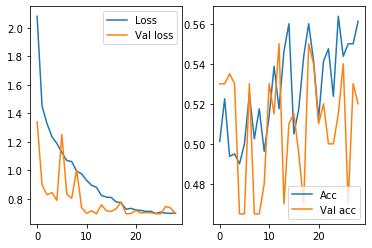

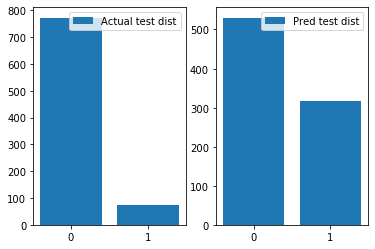

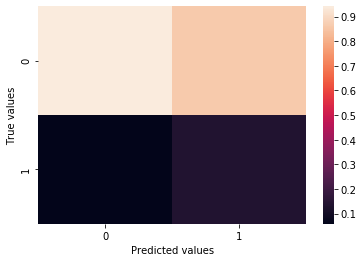

              precision    recall  f1-score   support

         0.0       0.94      0.65      0.77       772
         1.0       0.14      0.58      0.22        74

    accuracy                           0.64       846
   macro avg       0.54      0.61      0.49       846
weighted avg       0.87      0.64      0.72       846

Test accuracy: 0.641


In [75]:
model_1yr = create_model_ff(nodes1=nn_grid_result.best_params_['nodes1'],
                            nodes2=nn_grid_result.best_params_['nodes2'],
                            n_hidden=nn_grid_result.best_params_['n_hidden'],
                            dropout_rate=nn_grid_result.best_params_['dropout_rate'])

history_1yr = model_1yr.fit(x_train_1yr, y_train_1yr,
                            validation_split=0.2,
                            epochs=1000000,
                            batch_size=nn_grid_result.best_params_['batch_size'],
                            callbacks=[EarlyStopping(patience=10,restore_best_weights=True)],
                            verbose=1)

plot_results_nn(history_1yr,
                model_1yr,
                x_test_1yr,
                y_test_1yr,
                save=True,
                name='nn_1yr_n1{}_n2{}_de{}_dr{}'.format(nn_grid_result.best_params_['nodes1'],
                                                         nn_grid_result.best_params_['nodes2'],
                                                         nn_grid_result.best_params_['n_hidden'],
                                                         nn_grid_result.best_params_['dropout_rate']))

#### 3 year rate

In [ ]:
# Perform a cross-validation to find good values of hyperparameters

model_3yr = KerasClassifier(build_fn=create_model_ff, verbose=0)
# define the grid search parameters
batch_size = [8, 16, 32]
epochs = [5, 10, 15]
learning_rates = [1e-3, 1e-4, 1e-5]
nodes = [50,100, 250, 500]
depth = [1,2,3]
dropout_rates = [0.2, 0.5]
optimizers = ['rmsprop','adam']
nn_param_grid = dict(batch_size=batch_size,
                     epochs=epochs,
                     nodes=nodes,
                     dropout_rate=dropout_rates,
                     learning_rate=learning_rates,
                     depth=depth,
                     optimizer=optimizers)
nn_grid = GridSearchCV(estimator=model_3yr,
                       param_grid=nn_param_grid,
                       n_jobs=-1,
                       cv=3,
                       verbose=10)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    nn_grid_result = nn_grid.fit(x_train_3yr, y_train_3yr)
# summarize results
print("Best: %f using %s" % (nn_grid_result.best_score_, nn_grid_result.best_params_))
means = nn_grid_result.cv_results_['mean_test_score']
stds = nn_grid_result.cv_results_['std_test_score']
params = nn_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
model_3yr = create_model_ff(nodes=nn_grid_result.best_params_['nodes'],
                     depth=nn_grid_result.best_params_['depth'],
                     dropout_rate=nn_grid_result.best_params_['dropout_rate'])

history_3yr = model_3yr.fit(x_train_3yr, y_train_3yr,
                    validation_split=0.2,
                    epochs=100000, # Fitting is cancelled by early stopping callback
                    batch_size=nn_grid_result.best_params_['batch_size'],
                    callbacks=[EarlyStopping(patience=10,restore_best_weights=True)],
                    verbose=1)

plot_results_nn(history_3yr,
                model_3yr,
                x_test_3yr,
                y_test_3yr,
                save=True,
                name='nn_3yr_n{}_de{}_dr{}'.format(nn_grid_result.best_params_['nodes'],
                                                   nn_grid_result.best_params_['depth'],
                                                   nn_grid_result.best_params_['dropout_rate']))

#### S&P

In [ ]:
# Perform a cross-validation to find good values of hyperparameters

model_sp = KerasClassifier(build_fn=create_model_ff, verbose=0)
# define the grid search parameters
batch_size = [8, 16, 32]
epochs = [5, 10, 15]
learning_rates = [1e-3, 1e-4, 1e-5]
nodes = [50,100, 250, 500]
depth = [1,2,3]
dropout_rates = [0.2, 0.5]
optimizers = ['rmsprop','adam']
nn_param_grid = dict(batch_size=batch_size,
                     epochs=epochs,
                     nodes=nodes,
                     dropout_rate=dropout_rates,
                     learning_rate=learning_rates,
                     depth=depth,
                     optimizer=optimizers)
nn_grid = GridSearchCV(estimator=model_sp,
                       param_grid=nn_param_grid,
                       n_jobs=-1,
                       cv=3,
                       verbose=10)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    nn_grid_result = nn_grid.fit(x_train_sp, y_train_sp)
# summarize results
print("Best: %f using %s" % (nn_grid_result.best_score_, nn_grid_result.best_params_))
means = nn_grid_result.cv_results_['mean_test_score']
stds = nn_grid_result.cv_results_['std_test_score']
params = nn_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
model_sp = create_model_ff(nodes=nn_grid_result.best_params_['nodes'],
                     depth=nn_grid_result.best_params_['depth'],
                     dropout_rate=nn_grid_result.best_params_['dropout_rate'])

history_sp = model_sp.fit(x_train_sp, y_train_sp,
                    validation_split=0.2,
                    epochs=100000, # Fitting is cancelled by early stopping callback
                    batch_size=nn_grid_result.best_params_['batch_size'],
                    callbacks=[EarlyStopping(patience=10,restore_best_weights=True)],
                    verbose=1)

plot_results_nn(history_sp,
                model_sp,
                x_test_sp,
                y_test_sp,
                save=True,
                name='nn_sp_n{}_de{}_dr{}'.format(nn_grid_result.best_params_['nodes'],
                                                   nn_grid_result.best_params_['depth'],
                                                   nn_grid_result.best_params_['dropout_rate']))

## Results

The following results were achieved on the independent test set on the IMDB dataset. The reviews were encoded into 768-dimensional vectors using Sentence-BERT on each sentence in the reviews, and then reduced to one vector per review by taking the elementwise average over each dimension. 

| Model |  Test Accuracy (%)  | Hyperparameters |
| :----- | --------------- | --- | 
| Random Classifier | 50.6 | N/A |
| Logistic Regression | __90.7__  | N/A |
| Linear Discriminant Analysis | 90.3  | N/A |
| Support Vector Machine | 90.0 | N/A |
| Random Forest | 87.1  | n_estimators=5000, max_depth=None |
| XGBoost | 88.9 | n_estimators=500 |
| Multi Layer Perceptron | 89.8 | batch_size=16,depth=3,dropout_rate=0.2,nodes=250 |

Logistic Regression currently performs best. The hyperparameter tuning of the neural network-approaches is however not ideal, and would need more time/computational power to optimize further. It should however not be a too large improvement. Looking at the validation accuracy achieved from different configurations of hyperparameters on the neural network, it rarely reaches above 89 %. 

For comparison, the table below displays state-of-the-art models for the IMDB classification task. 

| Model |	Accuracy (%) |	Paper / Source|
|:----- | ---------- | -------------- |  
| XLNet (Yang et al., 2019) |	__96.21__ |	XLNet: Generalized Autoregressive Pretraining for Language Understanding|
| BERT_large+ITPT (Sun et al., 2019) 	|95.79 |	How to Fine-Tune BERT for Text Classification?|
| BERT_base+ITPT (Sun et al., 2019) |	95.63 |	How to Fine-Tune BERT for Text Classification?|
| ULMFiT (Howard and Ruder, 2018) |	95.4 |	Universal Language Model Fine-tuning for Text Classification|
| Block-sparse LSTM (Gray et al., 2017) |	94.99 |	GPU Kernels for Block-Sparse Weights|
| oh-LSTM (Johnson and Zhang, 2016)| 	94.1| 	Supervised and Semi-Supervised Text Categorization using LSTM for Region Embeddings |
| Virtual adversarial training (Miyato et al., 2016) |	94.1 	|Adversarial Training Methods for Semi-Supervised Text Classification |
| BCN+Char+CoVe (McCann et al., 2017) |	91.8 |	Learned in Translation: Contextualized Word Vectors |
